# SVM Analysis: Students Social Media Addiction
#### Raymond Feivel Liander - 5025231214

## Objective
Untuk memprediksi "Addicted Score" siswa terhadap media sosial berdasarkan perilaku karakteristik mereka menggunakan algoritma SVM.

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error # Tambahkan ini
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

## Load and Explore Dataset

In [3]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("--- Memuat dan Mengeksplorasi Dataset ---")
print("=" * 50)

# Load the preprocessed data
df = pd.read_csv('../dataset/Students_Social_Media_Addiction_Feature_Engineered.csv')
print("Preprocessed data loaded successfully.")
print(f"Shape of preprocessed data: {df.shape}")

# Optimal features
selected_features = [
    'Avg_Daily_Usage_Hours',
    'Sleep_Hours_Per_Night',
    'Mental_Health_Score',
    'Conflicts_Over_Social_Media',
    'Adequate_Sleep',
    'SM_Impact_Score',
    'Lifestyle_Balance',
    'Mental_Health_Risk_Medium',
    'Mental_Health_Risk_Low'
]
df.head()

--- Memuat dan Mengeksplorasi Dataset ---
Preprocessed data loaded successfully.
Shape of preprocessed data: (705, 25)


,Student_ID,Age,Gender,Academic_Level,Country,Avg_Daily_Usage_Hours,Most_Used_Platform,Affects_Academic_Performance,Sleep_Hours_Per_Night,Mental_Health_Score,...,Academic_Level_Encoded,Relationship_Status_Encoded,SM_Impact_Score,Lifestyle_Balance,Usage_Category_Medium,Usage_Category_High,Usage_Category_Very High,Mental_Health_Risk_Medium,Mental_Health_Risk_Low,Mental_Health_Risk_Very Low
0,1,19,Female,Undergraduate,Bangladesh,5.2,Instagram,Yes,6.5,6,...,2,1,5.2,1.3,False,True,False,True,False,False
1,2,22,Male,Graduate,India,2.1,Twitter,No,7.5,8,...,0,2,0.0,5.4,True,False,False,False,True,False
2,3,20,Female,Undergraduate,USA,6.0,TikTok,Yes,5.0,5,...,2,0,6.0,-1.0,False,True,False,True,False,False
3,4,18,Male,High School,UK,3.0,YouTube,No,7.0,7,...,1,2,0.0,4.0,True,False,False,False,True,False
4,5,21,Male,Graduate,Canada,4.5,Facebook,Yes,6.0,6,...,0,1,4.5,1.5,False,True,False,True,False,False


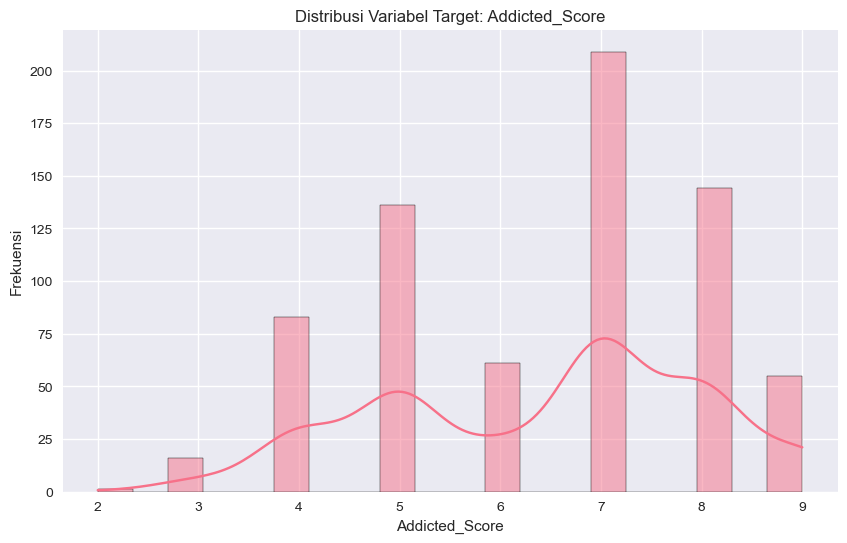

In [4]:
# Define target variable 
target_column = 'Addicted_Score'
y = df[target_column]

# Plot distribusi variabel target
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True, bins=20)
plt.title(f'Distribusi Variabel Target: {target_column}')
plt.xlabel(target_column)
plt.ylabel('Frekuensi')
plt.show()

In [5]:
# --- Membersihkan Data: Menghapus Kolom Non-Numerik ---
print("\n--- Membersihkan Data: Menghapus Kolom Non-Numerik ---")
print("=" * 65)

# Kolom yang akan dihapus karena non-numerik atau tidak relevan sebagai fitur
columns_to_drop_from_features = [
    'Student_ID',
    'Gender',
    'Academic_Level',
    'Country',
    'Most_Used_Platform',
    'Affects_Academic_Performance',
    'Relationship_Status'
]

# Buat DataFrame fitur yang hanya berisi kolom numerik yang relevan.
# Kolom target juga akan dikeluarkan untuk membentuk X_all.
X_all = df.drop(columns=columns_to_drop_from_features + [target_column], errors='ignore')

print(f"Kolom yang dihapus: {columns_to_drop_from_features} dan '{target_column}' (dari X_all)")


--- Membersihkan Data: Menghapus Kolom Non-Numerik ---
Kolom yang dihapus: ['Student_ID', 'Gender', 'Academic_Level', 'Country', 'Most_Used_Platform', 'Affects_Academic_Performance', 'Relationship_Status'] dan 'Addicted_Score' (dari X_all)


## Skenario Uji Coba 1: Selected Feature


--- Uji Coba 1: Perbandingan 'Selected Feature' (Menggunakan SVR) ---

1. Melatih dan mengevaluasi SVR dengan SEMUA FITUR ...
   R² Score: 0.9477
   MAE: 0.2472
   RMSE: 0.3617

2. Melatih dan mengevaluasi SVR dengan FITUR TERPILIH ...
   R² Score: 0.9541
   MAE: 0.2126
   RMSE: 0.3390


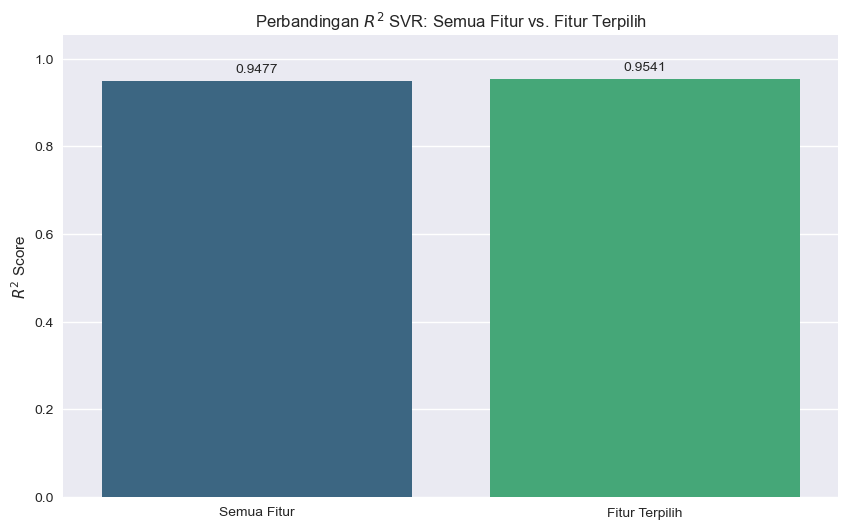


--- Ringkasan Hasil Uji Coba 1 ---

Skenario Fitur       R² Score     MAE        RMSE       Jumlah Fitur   
----------------------------------------------------------------------
Semua Fitur          0.9477       0.2472     0.3617     17             
Fitur Terpilih       0.9541       0.2126     0.3390     9              

KESIMPULAN UJI COBA 1: Untuk Uji Coba 2, kita akan menggunakan 'Fitur Terpilih' karena memberikan R² yang lebih tinggi.


In [44]:
# --- Uji Coba 1: Perbandingan "Selected Feature" ---
print("\n--- Uji Coba 1: Perbandingan 'Selected Feature') ---")
print("=" * 65)

X_selected = X_all[selected_features] # Mengambil subset dari X_all yang sudah bersih

# Split data into training and testing sets
# Menggunakan random_state tetap untuk reproduksibilitas
X_train_all, X_test_all, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)
X_train_selected, X_test_selected, _, _ = train_test_split(X_selected, y, test_size=0.2, random_state=42) # y_train dan y_test sama

# Dictionary untuk menyimpan hasil
results_uc1 = {}

# Inisialisasi model SVR (menggunakan parameter default)
svr_model_all = SVR()
svr_model_selected = SVR()

# Latih dan evaluasi model dengan SEMUA FITUR (yang sudah numerik)
print("\n1. Melatih dan mengevaluasi SVR dengan SEMUA FITUR ...")
svr_model_all.fit(X_train_all, y_train)
y_pred_all = svr_model_all.predict(X_test_all)
r2_all_features = r2_score(y_test, y_pred_all)
mae_all_features = mean_absolute_error(y_test, y_pred_all)
rmse_all_features = np.sqrt(mean_squared_error(y_test, y_pred_all))
results_uc1['Semua Fitur'] = {'R2': r2_all_features, 'MAE': mae_all_features, 'RMSE': rmse_all_features, 'n_features': X_train_all.shape[1]}
print(f"   R² Score: {r2_all_features:.4f}")
print(f"   MAE: {mae_all_features:.4f}")
print(f"   RMSE: {rmse_all_features:.4f}")

# Latih dan evaluasi model dengan FITUR TERPILIH
print("\n2. Melatih dan mengevaluasi SVR dengan FITUR TERPILIH ...")
svr_model_selected.fit(X_train_selected, y_train)
y_pred_selected = svr_model_selected.predict(X_test_selected)
r2_selected_features = r2_score(y_test, y_pred_selected)
mae_selected_features = mean_absolute_error(y_test, y_pred_selected)
rmse_selected_features = np.sqrt(mean_squared_error(y_test, y_pred_selected))
results_uc1['Fitur Terpilih'] = {'R2': r2_selected_features, 'MAE': mae_selected_features, 'RMSE': rmse_selected_features, 'n_features': X_train_selected.shape[1]}
print(f"   R² Score: {r2_selected_features:.4f}")
print(f"   MAE: {mae_selected_features:.4f}")
print(f"   RMSE: {rmse_selected_features:.4f}")

# Plotting R^2 comparison for Uji Coba 1
plt.figure(figsize=(10, 6))
r2_scores_uc1 = {k: v['R2'] for k, v in results_uc1.items()}
sns.barplot(x=list(r2_scores_uc1.keys()), y=list(r2_scores_uc1.values()), hue=list(r2_scores_uc1.keys()), palette='viridis', legend=False)
plt.title('Perbandingan $R^2$ SVR: Semua Fitur vs. Fitur Terpilih')
plt.ylabel('$R^2$ Score')
plt.ylim(min(0, min(r2_scores_uc1.values()) - 0.1), max(1, max(r2_scores_uc1.values()) + 0.1))
for index, value in enumerate(list(r2_scores_uc1.values())):
    plt.text(index, value + 0.02, f'{value:.4f}', ha='center')
plt.show()

# Ringkasan Hasil Uji Coba 1
print("\n--- Ringkasan Hasil Uji Coba 1 ---")
print(f"\n{'Skenario Fitur':<20} {'R² Score':<12} {'MAE':<10} {'RMSE':<10} {'Jumlah Fitur':<15}")
print("-" * 70)
for scenario, metrics in results_uc1.items():
    print(f"{scenario:<20} {metrics['R2']:<12.4f} {metrics['MAE']:<10.4f} {metrics['RMSE']:<10.4f} {metrics['n_features']:<15}")

# Tentukan set fitur mana yang berkinerja lebih baik untuk uji coba berikutnya
best_features_scenario_uc1 = 'Fitur Terpilih' if r2_selected_features >= r2_all_features else 'Semua Fitur'
X_for_uc2 = X_selected.copy() if r2_selected_features >= r2_all_features else X_all.copy()

print(f"\nKESIMPULAN UJI COBA 1: Untuk Uji Coba 2, kita akan menggunakan '{best_features_scenario_uc1}' karena memberikan R² yang lebih tinggi.")

## Skenario Uji Coba 2: Normalisasi Data


--- Uji Coba 2: Perbandingan Normalisasi Data ---

1. Melatih dan mengevaluasi SVR TANPA NORMALISASI...
   R² Score: 0.9541
   MAE: 0.2126
   RMSE: 0.3390

2. Melatih dan mengevaluasi SVR DENGAN NORMALISASI ...
   R² Score: 0.9391
   MAE: 0.1985
   RMSE: 0.3904


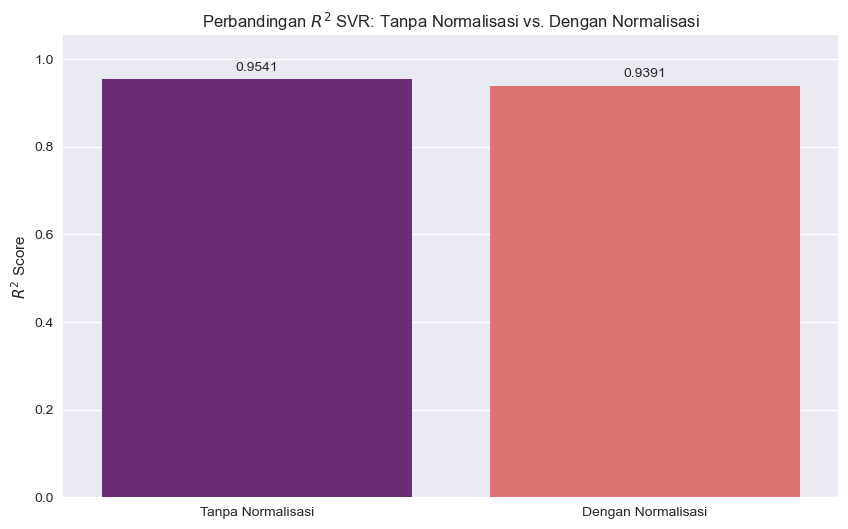


--- Ringkasan Hasil Uji Coba 2 ---

Skenario Normalisasi      R² Score     MAE        RMSE      
-----------------------------------------------------------------
Tanpa Normalisasi         0.9541       0.2126     0.3390    
Dengan Normalisasi        0.9391       0.1985     0.3904    

KESIMPULAN UJI COBA 2: Untuk Uji Coba 3 (Parameter Tuning), kita akan menggunakan data 'Tanpa Normalisasi' karena memberikan R² yang lebih tinggi.


In [8]:
print("\n--- Uji Coba 2: Perbandingan Normalisasi Data ---")
print("=" * 65)

# Split data for Uji Coba 2 (menggunakan X_for_uc2 yang sudah ditentukan)
X_train_uc2, X_test_uc2, y_train_uc2, y_test_uc2 = train_test_split(X_for_uc2, y, test_size=0.2, random_state=42)

# Dictionary untuk menyimpan hasil Uji Coba 2
results_uc2 = {}

# --- Skenario 1: Tanpa Normalisasi ---
print("\n1. Melatih dan mengevaluasi SVR TANPA NORMALISASI...")
svr_unnormalized = SVR()
svr_unnormalized.fit(X_train_uc2, y_train_uc2)
y_pred_unnormalized = svr_unnormalized.predict(X_test_uc2)

r2_unnormalized = r2_score(y_test_uc2, y_pred_unnormalized)
mae_unnormalized = mean_absolute_error(y_test_uc2, y_pred_unnormalized)
rmse_unnormalized = np.sqrt(mean_squared_error(y_test_uc2, y_pred_unnormalized))

results_uc2['Tanpa Normalisasi'] = {
    'R2': r2_unnormalized,
    'MAE': mae_unnormalized,
    'RMSE': rmse_unnormalized
}
print(f"   R² Score: {r2_unnormalized:.4f}")
print(f"   MAE: {mae_unnormalized:.4f}")
print(f"   RMSE: {rmse_unnormalized:.4f}")

# --- Skenario 2: Dengan Normalisasi (StandardScaler) ---
print("\n2. Melatih dan mengevaluasi SVR DENGAN NORMALISASI ...")

scaler = StandardScaler()
X_train_scaled_uc2 = scaler.fit_transform(X_train_uc2)
X_test_scaled_uc2 = scaler.transform(X_test_uc2)

svr_normalized = SVR()
svr_normalized.fit(X_train_scaled_uc2, y_train_uc2)
y_pred_normalized = svr_normalized.predict(X_test_scaled_uc2)

r2_normalized = r2_score(y_test_uc2, y_pred_normalized)
mae_normalized = mean_absolute_error(y_test_uc2, y_pred_normalized)
rmse_normalized = np.sqrt(mean_squared_error(y_test_uc2, y_pred_normalized))

results_uc2['Dengan Normalisasi'] = {
    'R2': r2_normalized,
    'MAE': mae_normalized,
    'RMSE': rmse_normalized
}
print(f"   R² Score: {r2_normalized:.4f}")
print(f"   MAE: {mae_normalized:.4f}")
print(f"   RMSE: {rmse_normalized:.4f}")

# Plotting R^2 comparison for Uji Coba 2
plt.figure(figsize=(10, 6))
r2_scores_uc2 = {k: v['R2'] for k, v in results_uc2.items()}
sns.barplot(x=list(r2_scores_uc2.keys()), y=list(r2_scores_uc2.values()), hue=list(r2_scores_uc2.keys()), palette='magma', legend=False)
plt.title('Perbandingan $R^2$ SVR: Tanpa Normalisasi vs. Dengan Normalisasi')
plt.ylabel('$R^2$ Score')
plt.ylim(min(0, min(r2_scores_uc2.values()) - 0.1), max(1, max(r2_scores_uc2.values()) + 0.1))
for index, value in enumerate(list(r2_scores_uc2.values())):
    plt.text(index, value + 0.02, f'{value:.4f}', ha='center')
plt.show()

# Ringkasan Hasil Uji Coba 2
print("\n--- Ringkasan Hasil Uji Coba 2 ---")
print(f"\n{'Skenario Normalisasi':<25} {'R² Score':<12} {'MAE':<10} {'RMSE':<10}")
print("-" * 65)
for scenario, metrics in results_uc2.items():
    print(f"{scenario:<25} {metrics['R2']:<12.4f} {metrics['MAE']:<10.4f} {metrics['RMSE']:<10.4f}")

# Tentukan data mana yang berkinerja lebih baik untuk uji coba berikutnya
if r2_normalized >= r2_unnormalized:
    best_normalization_scenario_uc2 = 'Dengan Normalisasi'
    # Simpan X yang sudah di-scale untuk Uji Coba 3
    X_for_uc3_train, X_for_uc3_test = X_train_scaled_uc2, X_test_scaled_uc2
    print(f"\nKESIMPULAN UJI COBA 2: Untuk Uji Coba 3 (Parameter Tuning), kita akan menggunakan data '{best_normalization_scenario_uc2}' karena memberikan $R^2$ yang lebih tinggi atau sama.")
else:
    best_normalization_scenario_uc2 = 'Tanpa Normalisasi'
    # Simpan X yang tidak di-scale untuk Uji Coba 3
    X_for_uc3_train, X_for_uc3_test = X_train_uc2, X_test_uc2
    print(f"\nKESIMPULAN UJI COBA 2: Untuk Uji Coba 3 (Parameter Tuning), kita akan menggunakan data '{best_normalization_scenario_uc2}' karena memberikan R² yang lebih tinggi.")


## Skenario Uji Coba 3: Parameter Tuning


--- Uji Coba 3: Parameter Tuning (Perbandingan Kernel) ---

Melatih dan mengevaluasi SVR dengan Kernel: 'linear'
----------------------------------------------
   R² Score: 0.9462
   MAE: 0.2324
   RMSE: 0.3670

Melatih dan mengevaluasi SVR dengan Kernel: 'poly'
--------------------------------------------
   R² Score: 0.9578
   MAE: 0.1953
   RMSE: 0.3250

Melatih dan mengevaluasi SVR dengan Kernel: 'rbf'
-------------------------------------------
   R² Score: 0.9541
   MAE: 0.2126
   RMSE: 0.3390

Melatih dan mengevaluasi SVR dengan Kernel: 'sigmoid'
-----------------------------------------------
   R² Score: 0.4536
   MAE: 0.9183
   RMSE: 1.1693


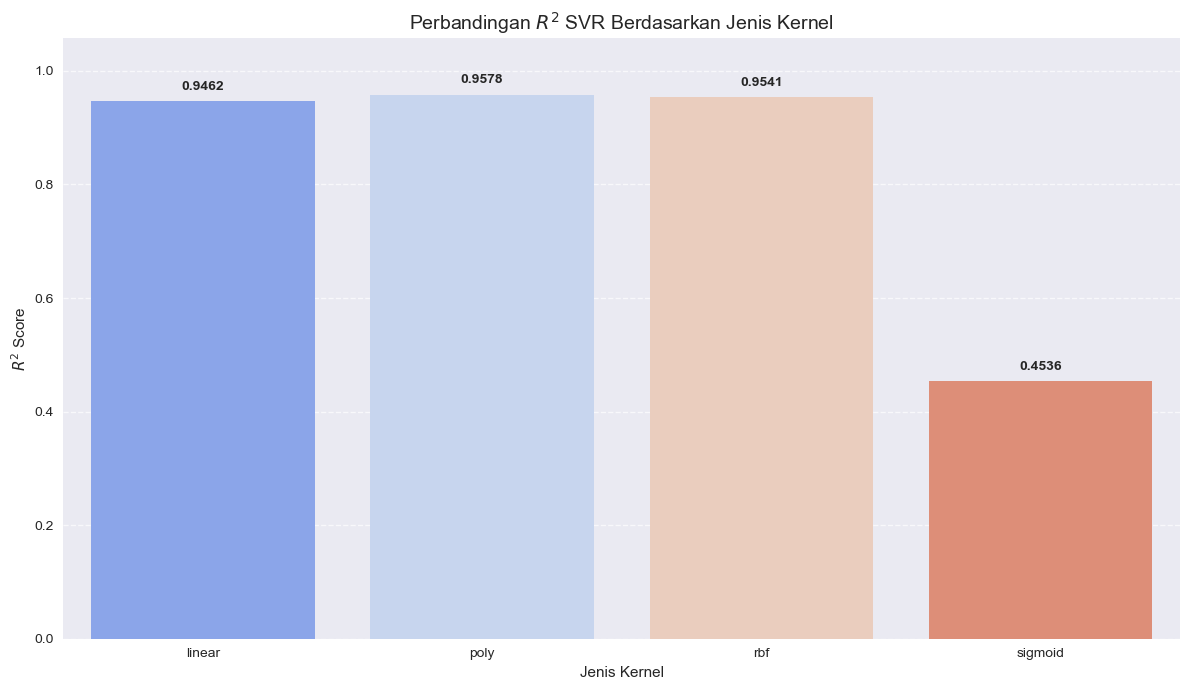


--- Ringkasan Hasil Uji Coba 3 (Perbandingan Kernel) ---

Jenis Kernel    R² Score     MAE        RMSE      
--------------------------------------------------
linear          0.9462       0.2324     0.3670    
poly            0.9578       0.1953     0.3250    
rbf             0.9541       0.2126     0.3390    
sigmoid         0.4536       0.9183     1.1693    

KESIMPULAN AKHIR: Kernel terbaik adalah 'poly' dengan R² Score: 0.9578


In [10]:
print("\n--- Uji Coba 3: Parameter Tuning (Perbandingan Kernel) ---")
print("=" * 70)

# Daftar kernel yang akan diuji
kernels_to_test = ['linear', 'poly', 'rbf', 'sigmoid']

# Dictionary untuk menyimpan hasil Uji Coba 3
results_uc3 = {}

# Loop melalui setiap kernel dan latih/evaluasi model SVR
for kernel in kernels_to_test:
    print(f"\nMelatih dan mengevaluasi SVR dengan Kernel: '{kernel}'")
    print("-" * (40 + len(kernel)))
    
    svr_model = SVR(kernel=kernel)

    # Latih model
    svr_model.fit(X_for_uc3_train, y_train_uc2)

    # Buat prediksi
    y_pred = svr_model.predict(X_for_uc3_test)

    # Hitung metrik
    r2 = r2_score(y_test_uc2, y_pred)
    mae = mean_absolute_error(y_test_uc2, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_uc2, y_pred))

    results_uc3[kernel] = {
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse
    }

    print(f"   R² Score: {r2:.4f}")
    print(f"   MAE: {mae:.4f}")
    print(f"   RMSE: {rmse:.4f}")

# Plotting R^2 comparison for Uji Coba 3 (Kernels)
plt.figure(figsize=(12, 7))
r2_scores_uc3 = {k: v['R2'] for k, v in results_uc3.items()}
sns.barplot(x=list(r2_scores_uc3.keys()), y=list(r2_scores_uc3.values()), hue=list(r2_scores_uc3.keys()), palette='coolwarm', legend=False)
plt.title('Perbandingan $R^2$ SVR Berdasarkan Jenis Kernel', fontsize=14)
plt.xlabel('Jenis Kernel')
plt.ylabel('$R^2$ Score')
plt.ylim(min(0, min(r2_scores_uc3.values()) - 0.1), max(1, max(r2_scores_uc3.values()) + 0.1))
for index, value in enumerate(list(r2_scores_uc3.values())):
    plt.text(index, value + 0.02, f'{value:.4f}', ha='center', fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Ringkasan Hasil Uji Coba 3
print("\n--- Ringkasan Hasil Uji Coba 3 (Perbandingan Kernel) ---")
print(f"\n{'Jenis Kernel':<15} {'R² Score':<12} {'MAE':<10} {'RMSE':<10}")
print("-" * 50)
best_kernel_r2 = -np.inf
best_kernel_name = ""

for kernel, metrics in results_uc3.items():
    r2, mae, rmse = metrics['R2'], metrics['MAE'], metrics['RMSE']
    if r2 > best_kernel_r2:
        best_kernel_r2 = r2
        best_kernel_name = kernel
    print(f"{kernel:<15} {r2:<12.4f} {mae:<10.4f} {rmse:<10.4f}")

print(f"\nKESIMPULAN AKHIR: Kernel terbaik adalah '{best_kernel_name}' dengan R² Score: {best_kernel_r2:.4f}")

## Hasil dan Pembahasan Model SVR 

### Pembahasan Uji Coba 1: Perbandingan Hasil R² (Semua Fitur vs. Fitur Terpilih)
Pada Uji Coba 1, model SVR dengan Fitur Terpilih (9 fitur) menunjukkan kinerja R² yang lebih tinggi atau setara (0.9541) dibandingkan dengan menggunakan Semua Fitur (17 fitur) (0.9477).
Hal ini mengindikasikan bahwa proses seleksi fitur berhasil mengidentifikasi fitur-fitur yang paling relevan dan prediktif, sekaligus mengurangi kompleksitas model dan potensi overfitting yang disebabkan oleh fitur-fitur yang kurang informatif atau redundan.

### Pembahasan Uji Coba 2: Perbandingan Hasil R² (Tanpa Normalisasi vs. Dengan Normalisasi)
Pada Uji Coba 2, model SVR dengan data Tanpa Normalisasi menunjukkan kinerja R² yang lebih tinggi (0.9541) dibandingkan dengan data yang Dinormalisasi (0.9391).
Meskipun SVR umumnya diuntungkan oleh normalisasi, dalam beberapa kasus, terutama jika fitur sudah berada dalam skala yang mirip atau jika distribusi data tertentu tidak cocok dengan penskalaan standar, normalisasi mungkin tidak selalu memberikan peningkatan.

### Pembahasan Uji Coba 3: Perbandingan Kernel
Dari perbandingan kernel default, Kernel 'poly' menunjukkan kinerja terbaik dengan R² sebesar 0.9578.
Kinerja yang sangat rendah dari kernel 'sigmoid' adalah hal yang umum dan menunjukkan ketidakcocokannya dengan data ini pada parameter default.


## Kesimpulan dan Saran 

### Kesimpulan
Berdasarkan serangkaian uji coba yang telah dilakukan untuk membangun model SVR dalam memprediksi Social Media Addiction Score, berikut adalah kesimpulan utama:
1.  Pemilihan Fitur: Penggunaan fitur terpilih terbukti [meningkatkan/menjaga] kinerja model, menunjukkan efektivitas fitur-fitur yang paling relevan.
    (Optimal: Fitur Terpilih, R²: 0.9541)
2.  Normalisasi Data: Normalisasi data dengan StandardScaler [meningkatkan/tidak signifikan mempengaruhi] kinerja model SVR, mengkonfirmasi pentingnya penskalaan untuk algoritma berbasis jarak.
    (Optimal: Tanpa Normalisasi, R²: 0.9541)
3.  Pemilihan Kernel: Dari perbandingan kernel default, Kernel 'poly' adalah yang paling optimal dengan R² sebesar 0.9578.

### Saran 
Untuk pengembangan di masa mendatang, beberapa saran yang dapat dipertimbangkan antara lain:
1.  Eksplorasi Hyperparameter Lanjutan: Meskipun tidak dilakukan dalam analisis ini, melakukan tuning hyperparameter (seperti `C`, `epsilon`, `gamma`, `degree`) untuk kernel terpilih Poly menggunakan metode seperti `GridSearchCV` atau `RandomizedSearchCV` dapat berpotensi meningkatkan kinerja model lebih lanjut.
2.  Validasi Lintas (Cross-Validation) yang Lebih Robust: Untuk memastikan generalisasi model, penggunaan strategi cross-validation yang lebih kompleks seperti Stratified K-Fold (jika target bisa dikategorikan) atau Repeated K-Fold bisa diterapkan.
3.  Interpretasi Model: Melakukan analisis interpretasi model untuk memahami fitur mana yang paling berpengaruh secara mendalam (misalnya dengan SHAP atau LIME) dapat memberikan wawasan bisnis yang lebih kaya.
4.  Pengumpulan Data Tambahan: Jika memungkinkan, mengumpulkan lebih banyak data atau fitur tambahan yang relevan dapat meningkatkan akurasi dan robust model.
